In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from src.model import GeometricLoss, get_model
from src.data import get_data

from config import MODELS_DIR, BATCH_SIZE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 100

In [ ]:
train_loader, test_loader = get_data(BATCH_SIZE)

model = get_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
# reduce LR 10x for 5 epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


/tmp/ipykernel_329001/3018787613.py:10: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  scheduler.step()


In [ ]:
criterion_ce = nn.CrossEntropyLoss()
criterion_supcon = GeometricLoss(temperature=0.1)
alpha = 0.5  # contrastive loss weight

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        features, logits = model(inputs)
        
        loss_ce = criterion_ce(logits, labels)
        loss_sc = criterion_supcon(features, labels)
        loss = loss_ce + (alpha * loss_sc)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = logits.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
    
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            _, logits = model(inputs)
            
            loss = criterion_ce(logits, labels) # only on cross entropy

            val_loss += loss.item()
            _, predicted = logits.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_train_acc = 100. * train_correct / train_total
    epoch_val_acc = 100. * val_correct / val_total
    
    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(epoch_train_acc)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")
    
    scheduler.step()
    
save_path = os.path.join(MODELS_DIR, "resnet18_cifar100.pth")
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
}, save_path)

Epoch 1/100 | Train Acc: 8.44% | Val Acc: 12.65%
Epoch 2/100 | Train Acc: 14.94% | Val Acc: 16.33%
Epoch 3/100 | Train Acc: 19.43% | Val Acc: 18.47%
Epoch 4/100 | Train Acc: 24.10% | Val Acc: 26.59%
Epoch 5/100 | Train Acc: 28.37% | Val Acc: 28.52%
Epoch 6/100 | Train Acc: 32.24% | Val Acc: 32.77%
Epoch 7/100 | Train Acc: 35.98% | Val Acc: 35.24%
Epoch 8/100 | Train Acc: 39.37% | Val Acc: 37.19%
Epoch 9/100 | Train Acc: 42.17% | Val Acc: 40.69%
Epoch 10/100 | Train Acc: 45.11% | Val Acc: 43.30%
Epoch 11/100 | Train Acc: 47.23% | Val Acc: 46.60%
Epoch 12/100 | Train Acc: 49.85% | Val Acc: 44.61%
Epoch 13/100 | Train Acc: 51.86% | Val Acc: 50.11%
Epoch 14/100 | Train Acc: 54.28% | Val Acc: 49.53%
Epoch 15/100 | Train Acc: 55.94% | Val Acc: 51.87%
Epoch 16/100 | Train Acc: 57.44% | Val Acc: 53.59%
Epoch 17/100 | Train Acc: 59.18% | Val Acc: 55.22%
Epoch 18/100 | Train Acc: 60.60% | Val Acc: 54.61%
Epoch 19/100 | Train Acc: 62.15% | Val Acc: 56.76%
Epoch 20/100 | Train Acc: 63.27% | Val Ac

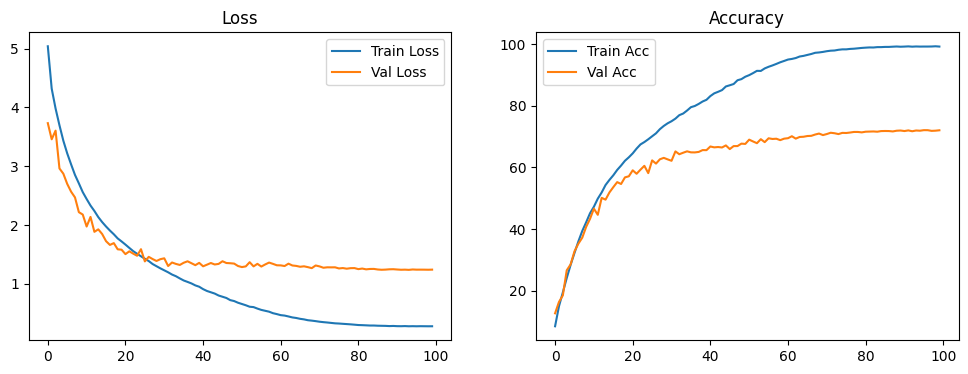

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Accuracy')
plt.show()